<a href="https://colab.research.google.com/github/eric-castillo05/emotions-wheel-nlp/blob/main/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter
from typing import List
from wordcloud import WordCloud
import kagglehub
import numpy as np

In [4]:
path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

100%|██████████| 721k/721k [00:00<00:00, 89.8MB/s]

Extracting files...


In [10]:
def read_dataset(name: str) -> pl.DataFrame:
  with open (path+f'/{name}.txt', "r", encoding = "utf-8") as f:
    raw_data = f.readlines()
  texts = []
  labels = []

  for text in raw_data:
    if ';' in text:
      t, l = text.strip().split(';')
      labels.append(l)
      texts.append(t)
  return pl.DataFrame({'text': texts, 'label': labels})

In [11]:
df_train = read_dataset('train')

In [12]:
df_train.head()

text,label
str,str
"""i didnt feel humiliated""","""sadness"""
"""i can go from feeling so hopel…","""sadness"""
"""im grabbing a minute to post i…","""anger"""
"""i am ever feeling nostalgic ab…","""love"""
"""i am feeling grouchy""","""anger"""


In [13]:
df_train.describe()

statistic,text,label
str,str,str
"""count""","""16000""","""16000"""
"""null_count""","""0""","""0"""
"""mean""",null,null
"""std""",null,null
"""min""","""a boyfriend with whom i split …","""anger"""
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""while cycling in the country""","""surprise"""


In [14]:
!python3 -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
nlp = spacy.load('en_core_web_lg')

In [17]:
docs_train = list(nlp.pipe(df_train.select('text').to_series().to_list()))

In [18]:
token_lists = [[token.text for token in doc] for doc in docs_train]

In [19]:
token_counts = [len([t for t in doc if not t.is_punct and not t.is_space]) for doc in docs_train]

In [21]:
min_idx = token_counts.index(min(token_counts))
print(f"Renglón con MENOS tokens: {df_train.get_column('text')[min_idx]}")
print(f"Tamaño: {len(df_train.get_column('text')[min_idx])}")

Renglón con MENOS tokens: earth crake
Tamaño: 11


In [22]:
max_idx = token_counts.index(max(token_counts))
print(f"Renglón con MÁs tokens: {df_train.get_column('text')[max_idx]}")
print(f"Tamaño: {len(df_train.get_column('text')[max_idx])}")

Renglón con MÁs tokens: i feel in my bones like nobody cares if im here nobody cares if im gone here i am again saying im feeling so lonely people either say its ok to be alone or just go home it kills me and i dont know why it doesnt mean i dont try i try and try but people just treat me like im a ghost
Tamaño: 281


In [23]:
unigrams = [
    token.text.lower() for doc in docs_train for token in doc
    if not token.is_stop and not token.is_punct and not token.is_space
]

unigram_counts = Counter(unigrams)

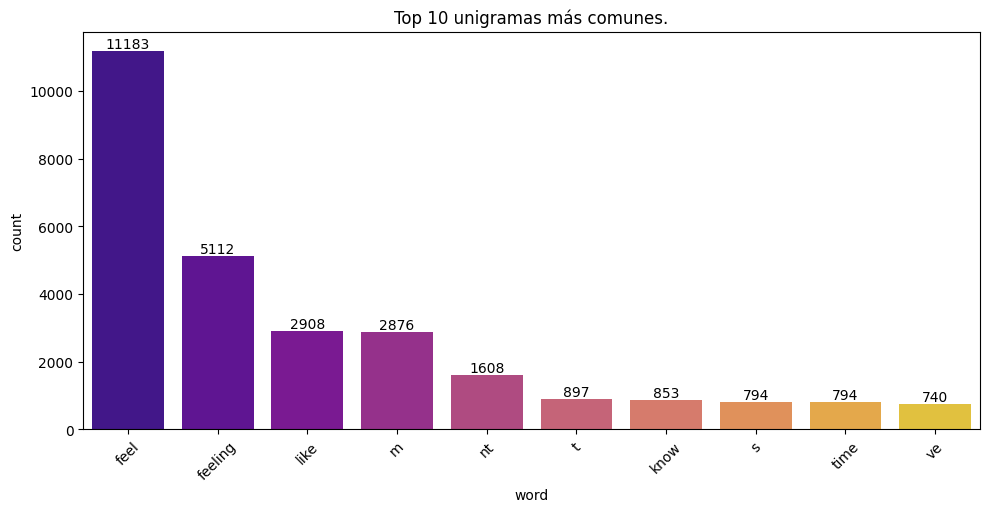

In [26]:
df_unigram_counts = pl.DataFrame(
    data = unigram_counts.most_common(10),
    schema = ['word', 'count'],
    orient = 'row'
)
plt.figure(figsize = (10, 5))
ax = sns.barplot(
    data = df_unigram_counts,
    x = 'word',
    y = 'count',
    hue = 'word',
    palette = 'plasma'
)
for container in ax.containers:
    ax.bar_label(container,
                 fmt = '%.0f',
                 label_type = 'edge',
                 padding = 0)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Top 10 unigramas más comunes.')
plt.savefig('img/unigramas_mas_comunes.png', dpi = 400)
plt.show()

In [27]:
def extract_multiword_terms(text: str) -> List[str]:
    text = re.sub(r'[^\w\s]', '', text.lower())
    doc = nlp(text)
    return [
        chunk.text for chunk in doc.noun_chunks
        if len(chunk.text.split()) >= 2
    ]

In [28]:
multiword_phrases = df_train.select('text').to_series().to_list()

In [29]:
all_terms = []
for text in multiword_phrases:
    all_terms.extend(extract_multiword_terms(text))

In [30]:
term_counter = Counter(all_terms)

In [31]:
for term, freq in term_counter.most_common(10):
    print(f'{term} : {freq}')

i don t : 290
my life : 209
the feeling : 206
a lot : 154
a feeling : 130
the world : 111
the way : 99
the time : 87
my heart : 83
my feelings : 79


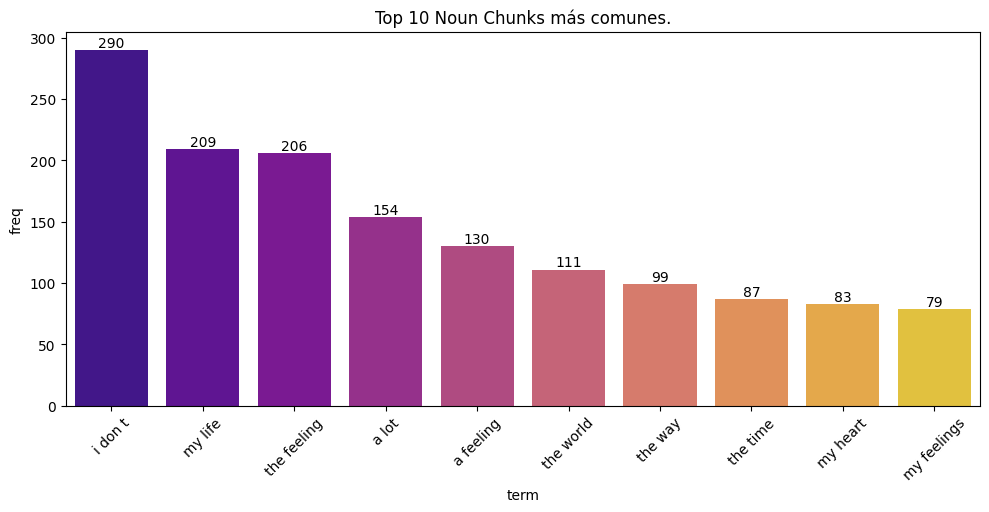

In [32]:
df_noun_chunks = pl.DataFrame(
    data = term_counter.most_common(10),
    schema = ['term', 'freq'],
    orient = 'row'
)
plt.figure(figsize = (10, 5))
ax = sns.barplot(
    data = df_noun_chunks,
    x = 'term',
    y = 'freq',
    hue = 'term',
    palette = 'plasma'
)
for container in ax.containers:
    ax.bar_label(
        container,
        fmt = '%.0f',
        label_type = 'edge',
        padding = 0
    )
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Top 10 Noun Chunks más comunes.')
plt.savefig('img/noun_chunks_mas_comunes.png', dpi = 400)
plt.show()

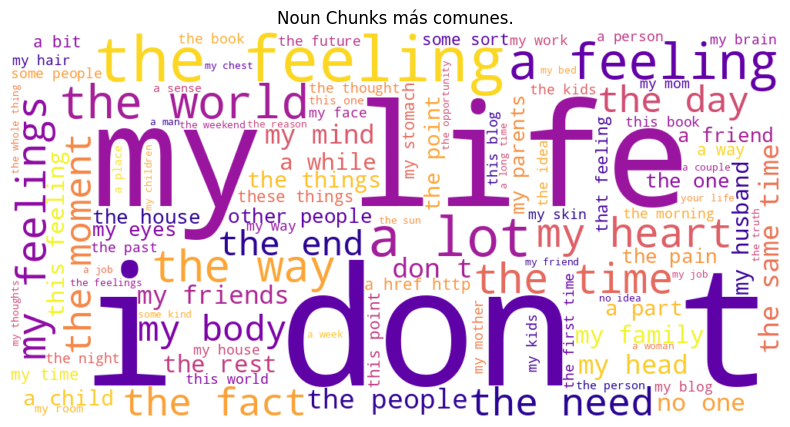

In [33]:
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    max_words = 100,
    background_color = 'white',
    colormap = 'plasma'
).generate_from_frequencies(term_counter)
plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Noun Chunks más comunes.')
plt.savefig('img/word_cloud_noun_chunks.png', dpi = 400)
plt.show()

# Vader Metric

In [34]:
%pip install nltk

In [35]:
import nltk

In [36]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [38]:
analyzer = SentimentIntensityAnalyzer()

In [40]:
temp = []
for s in df_train.select('text').to_series():
    temp.append([s, (analyzer.polarity_scores(s))])

In [41]:
aux_temp = [{'text': row[0], **row[1]} for row in temp]

In [42]:
df_vader_score = pl.from_dicts(aux_temp)

In [43]:
df_vader_score.head()

text,neg,neu,pos,compound
str,f64,f64,f64,f64
"""i didnt feel humiliated""",0.0,0.496,0.504,0.2584
"""i can go from feeling so hopel…",0.227,0.503,0.271,0.0821
"""im grabbing a minute to post i…",0.474,0.526,0.0,-0.6597
"""i am ever feeling nostalgic ab…",0.0,0.909,0.091,0.128
"""i am feeling grouchy""",0.537,0.185,0.278,-0.34


In [44]:
df_vader_score.describe()

statistic,text,neg,neu,pos,compound
str,str,f64,f64,f64,f64
"""count""","""16000""",16000.0,16000.0,16000.0,16000.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,0.159427,0.642703,0.197868,0.083413
"""std""",null,0.165495,0.162086,0.166836,0.553584
"""min""","""a boyfriend with whom i split …",0.0,0.0,0.0,-0.984
"""25%""",null,0.0,0.544,0.07,-0.4215
"""50%""",null,0.126,0.659,0.175,0.1043
"""75%""",null,0.254,0.758,0.294,0.5859
"""max""","""while cycling in the country""",0.948,1.0,1.0,0.9847


In [45]:
def get_label(n: float) -> str:
    if n >= 0.05: return 'positive'
    elif n <= -0.05: return 'negative'
    return 'neutral'

In [46]:
df_vader_score = df_vader_score.with_columns([
    pl.col('compound').map_elements(get_label, return_dtype = pl.Utf8).alias('label')
])

In [47]:
df_vader_score.head()

text,neg,neu,pos,compound,label
str,f64,f64,f64,f64,str
"""i didnt feel humiliated""",0.0,0.496,0.504,0.2584,"""positive"""
"""i can go from feeling so hopel…",0.227,0.503,0.271,0.0821,"""positive"""
"""im grabbing a minute to post i…",0.474,0.526,0.0,-0.6597,"""negative"""
"""i am ever feeling nostalgic ab…",0.0,0.909,0.091,0.128,"""positive"""
"""i am feeling grouchy""",0.537,0.185,0.278,-0.34,"""negative"""


In [48]:
df_vader_score.describe()

statistic,text,neg,neu,pos,compound,label
str,str,f64,f64,f64,f64,str
"""count""","""16000""",16000.0,16000.0,16000.0,16000.0,"""16000"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,0.159427,0.642703,0.197868,0.083413,null
"""std""",null,0.165495,0.162086,0.166836,0.553584,null
"""min""","""a boyfriend with whom i split …",0.0,0.0,0.0,-0.984,"""negative"""
"""25%""",null,0.0,0.544,0.07,-0.4215,null
"""50%""",null,0.126,0.659,0.175,0.1043,null
"""75%""",null,0.254,0.758,0.294,0.5859,null
"""max""","""while cycling in the country""",0.948,1.0,1.0,0.9847,"""positive"""


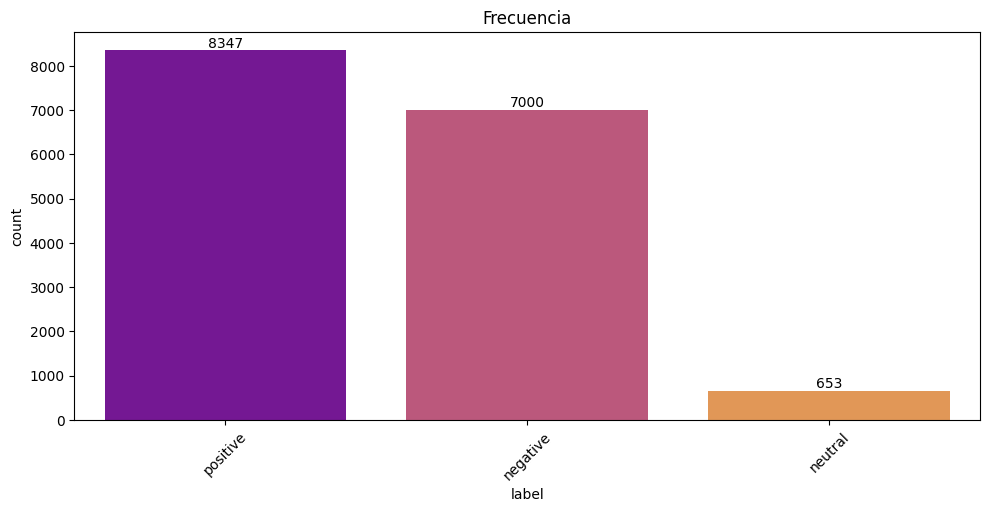

In [49]:
plt.figure(figsize = (10, 5))

ax = sns.countplot(data = df_vader_score,
                x = 'label',
                hue = 'label',
                palette = 'plasma',
        )
for container in ax.containers:
    ax.bar_label(container, fmt = '%.0f', label_type = 'edge', padding = 0)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Frecuencia')
plt.savefig('img/vader_score.png', dpi = 400)
plt.show()